In [1]:
import numpy as np
import scipy as sp
from scipy import spatial
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = 10, 8

### Fast clusterization of adjacency matrices
Taken from this [blog](http://raphael.candelier.fr/?blog=Adj2cluster)

In [3]:
def make_nodes_grid(m, n):
    # m: number of row in the network
    # n: number of columns in the network
    
    Y, X = np.meshgrid(np.linspace(1, m, m), np.linspace(1, n, n), sparse=False, indexing='ij')
    for i in np.arange(1, m, 2):
        X[i, :] = X[i, :] + 1/2
    Y = Y*np.sqrt(3)/2
    x = np.reshape(X, (-1), order='F')
    y = np.reshape(Y, (-1), order='F')
    return x, y

def random_adjacency_matrix(m, n, p):
    # m: number of row in the network
    # n: number of columns in the network
    # p: Link probability

    x, y = make_nodes_grid(m, n)
    tri = sp.spatial.Delaunay(np.c_[x, y])
    T = tri.simplices
    tmp = np.r_[np.c_[T[:, 0], T[:, 1]],
               np.c_[T[:, 0], T[:, 2]],
               np.c_[T[:, 1], T[:, 2]]]
    links = np.unique(np.c_[np.minimum(tmp[:, 0], tmp[:, 1]), np.maximum(tmp[:, 0], tmp[:, 1])], axis=0)
    L = links[np.random.rand(len(links)) <= p, :]
    A = sp.sparse.coo_matrix((np.ones(len(L)), (L[:, 0], L[:, 1])), shape=(m*n, m*n))
    return A
    
def show_adjacency_matrix(A, m, n):
    # A: sparse matrix
    # m: number of row in the network
    # n: number of columns in the network
    
    x, y = make_nodes_grid(m, n)
    for i, j in zip(A.row, A.col):
        plt.plot([x[i], x[j]], [y[i], y[j]], c='b')
    plt.plot(x, y, 'ob')
    plt.axis('off')
    
def adjacency_2_cluster(A):    
    # A: sparse matrix
    
    # Reverse Cuthill-McKee ordering
    S = A + np.transpose(A)
    r = sp.sparse.csgraph.reverse_cuthill_mckee(S)[::-1]
    # Get the clusters
    C = [[r[0]]]
    for i in range(1,r.size):
        if any(S[C[-1], r[i]]):
            C[-1].append(r[i])
        else:
            C.append([r[i]])
    return C

def show_clusters(A, C, m, n):
    # A: sparse matrix
    # C: clusters
    # m: number of row in the network
    # n: number of columns in the network
    
    x, y = make_nodes_grid(m, n)
    color = plt.rcParams['axes.prop_cycle'].by_key()['color']
    ncolor = len(color)
    k = 0
    for c in C:
        for e in c:
            for i, j in zip(A.row, A.col):
                if e in (i, j):
                    plt.plot([x[i], x[j]], [y[i], y[j]], c=color[k % ncolor])
            plt.plot(x[e], y[e], 'o', c=color[k % ncolor])
        k = k + 1
    plt.axis('off')

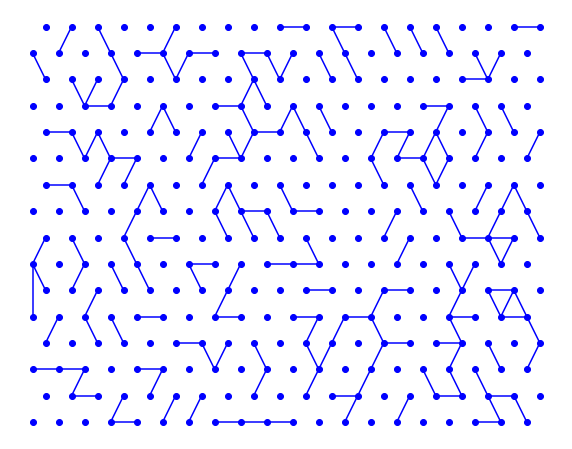

In [4]:
m = 16
n = 20
A = random_adjacency_matrix(m, n, 0.2)
show_adjacency_matrix(A, m, n)

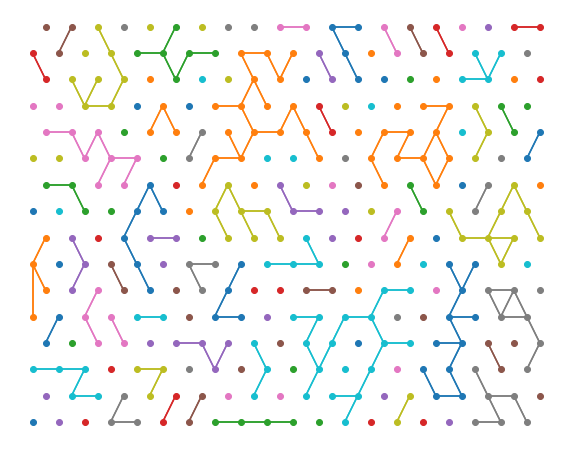

In [5]:
C = adjacency_2_cluster(A)
show_clusters(A, C, m, n)